In [1]:
#Import necessary packages

import numpy as np
from obspy import read, read_inventory
from obspy.clients.nrl import NRL
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from obspy import UTCDateTime
#import prepcorr as pc
from scipy import signal
import pickle
from obspy.io.xseed import Parser
from obspy.signal import PPSD
nrl = NRL()

In [2]:
#Read in data from pair of stations

#stn = read(r'C:\Users\souellet\mseed\350096097*.miniseed')
#stn = read(r'C:\Users\souellet\mseed\350101313*.miniseed')
stn = read(r'C:\Users\souellet\mseed\350107399*.miniseed')


In [3]:
stn.sort()

52 Trace(s) in Stream:

SS.07399..DPZ | 2020-06-16T19:56:54.000000Z - 2020-06-17T03:00:00.000000Z | 500.0 Hz, 12693001 samples
...
(50 other traces)
...
SS.07399..DPZ | 2020-08-06T15:01:28.000000Z - 2020-08-06T15:28:06.000000Z | 500.0 Hz, 799001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

- *Recording interval is from approximately 15:00:00 to 03:00:00 UTC.*
- *Daily construction is typically from approximately 12:00:00 to 24:00:00 UTC*

In [8]:
#Decimate sampling rate by a factor of 2 (500 Hz to 250 Hz)
st=stn.copy()
st.decimate(2)

52 Trace(s) in Stream:

SS.07399..DPZ | 2020-06-16T19:56:54.000000Z - 2020-06-17T03:00:00.000000Z | 250.0 Hz, 6346501 samples
...
(50 other traces)
...
SS.07399..DPZ | 2020-08-06T15:01:28.000000Z - 2020-08-06T15:28:06.000000Z | 250.0 Hz, 399501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

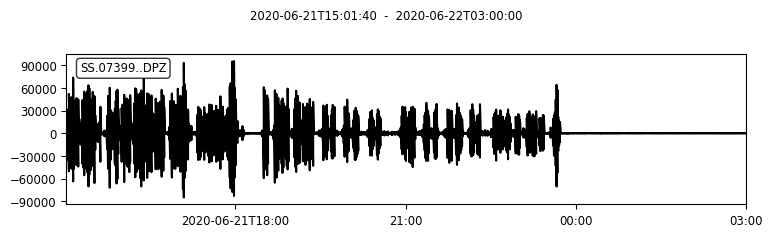

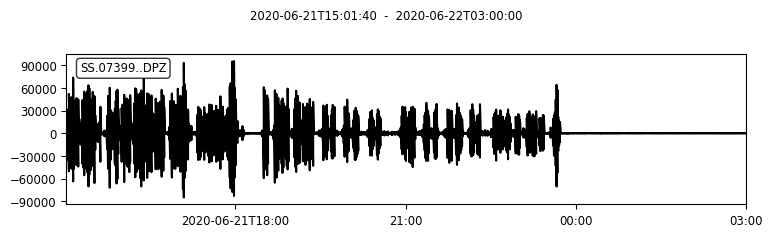

In [90]:
tr=st[5]
tr.plot()

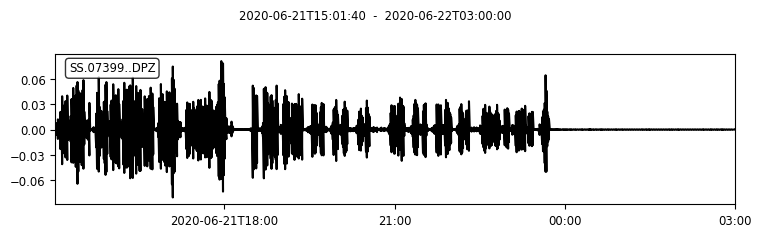

In [91]:
node_response = nrl.get_response(sensor_keys=['DTCC (manuafacturers of SmartSolo)','5 Hz', 'Rc=1850, Rs=430000'], datalogger_keys=['DTCC (manufacturers of SmartSolo', 'SmartSolo IGU-16', '24 dB (16)','500','Linear Phase','DC Removal'])
tr.stats.response=node_response

f_min = 4.0
f_max = 50.

pre_filt = [0.9*f_min, f_min, f_max, 1.1*f_max]
tr.remove_response(output='VEL', water_level=150, pre_filt=pre_filt,zero_mean=True, taper=True, taper_fraction=0.05,plot=False)

fig = tr.plot()

In [92]:
print(tr)
w  = tr.data
Fs = tr.stats.sampling_rate
t_unix = tr.times('timestamp')
t_mpl = tr.times('matplotlib')

SS.07399..DPZ | 2020-06-21T15:01:40.000000Z - 2020-06-22T03:00:00.000000Z | 250.0 Hz, 10775001 samples


In [93]:
from scipy import signal
from datetime import timedelta

window_length = 2.
segment_size = int(window_length*Fs)
oversampling = 4
overlap = 50.0
f_min = 1/window_length

(f, tf, Pxx) = signal.spectrogram(w, Fs,  
                                  window=('hanning'),
                                  nperseg=segment_size, 
                                  nfft=oversampling*segment_size, 
                                  noverlap=(overlap/100)*segment_size,
                                  scaling='density'
                                 )
tf_vec = [timedelta(seconds=t) + tr.stats.starttime.datetime for t in tf ]
tf_mpl = mdates.date2num(tf_vec)

# Select the frequencies of interest
idx = np.where((f>=f_min) & (f<=f_max))
Pxx = Pxx[idx]
f = f[idx]

# Convert to dB re 20e-6 Pa/sqrt(Hz)
P_ref = 20.0e-6
Pxx_dB = 10*np.log10(np.sqrt(Pxx)/np.power(P_ref,2))


In [98]:
t_mpl[0], t_mpl[-1]
print(pt0,pt1)

2020-06-22T00:01:40.000000Z 2020-06-22T03:00:00.000000Z


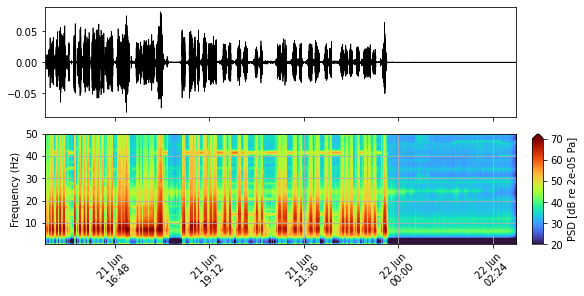

In [102]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, AutoLocator, FixedLocator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
#############################################
# Ploting parameters
dB_min =  20.
dB_max =  70.0

n_frames = 2
fig, ax = plt.subplots(n_frames, 1, sharex=True, figsize=(8,4), constrained_layout=True)


formatter = ScalarFormatter()
formatter.set_scientific(False)

########################################################################################
# Waveform
i = 0

ax[i].axhline(y=0, color='black', linewidth=1, linestyle=':')
ax[i].plot(t_mpl, w, 'k', linewidth=0.7)

########################################################################################
## Spectrogram
i += 1
extent = (t_mpl[0], t_mpl[-1], f_min, f_max)
im = ax[i].imshow(Pxx_dB, origin='lower', extent=extent, cmap='turbo',
             vmin=dB_min, vmax=dB_max, interpolation='bilinear')
#ax[i].set_yscale('log')
ax[i].set(ylabel='Frequency (Hz)')
ax[i].axis('tight')
ax[i].set_aspect('auto')
ax[i].set_ylim([f_min, f_max])
ax[i].grid()
ax[i].yaxis.set_major_formatter(formatter)
#ax[i].yaxis.set_major_locator(FixedLocator([0.3, 1.0, 3.0]))
# Add colorbar
cbar_label = 'PSD [dB re {} Pa]'.format(P_ref)
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')

## Datetime formatting 
# Choose your xtick format string
date_fmt = '%d %b\n%H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax[n_frames-1].xaxis.set_major_formatter(date_formatter)
ax[n_frames-1].tick_params(axis='x', rotation=45)
